<a href="https://colab.research.google.com/github/HaoboChen11/Gibbs-Based-Information-Criteria-and-the-Over-Parameterized-Regime/blob/main/Simulation_Gibbs_bics%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
###########################DATA GENERATIING################
import torch
import numpy as np
from scipy.stats import multivariate_normal
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from torch.optim import Optimizer
from torch.autograd import grad
from torch.utils.data import TensorDataset

from sklearn.metrics import mean_squared_error


np.random.seed(42)

# Define the number of samples and input dimension
num_samples = 333
input_dimension = 400

# Generate random input values (X) and coefficients for the linear combination
X = np.random.uniform(-1, 1, (num_samples, input_dimension))
coefficients = np.random.normal(0, 1, input_dimension)
coefficients /= np.linalg.norm(coefficients)

def linear_combination(x, coeffs):
    return np.dot(x, coeffs)

Y = linear_combination(X, coefficients)

# Add Gaussian noise to the output
noise_mean = 0
noise_std = 1
noise =np.random.normal(noise_mean, noise_std, size=Y.shape)
Y_noisy =3* (Y + 0.1*noise)+3


# Convert X and Y_noisy to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_noisy_tensor = torch.tensor(Y_noisy, dtype=torch.float32)

# Create a TensorDataset from the generated data
dataset = TensorDataset(X_tensor, Y_noisy_tensor)

# Split the dataset into training and testing sets with an 8:2 ratio
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, (train_size, test_size))

# Create DataLoaders for the training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import numpy as np
from scipy.stats import multivariate_normal
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from torch.optim import Optimizer
from torch.autograd import grad
from torch.utils.data import TensorDataset

from sklearn.metrics import mean_squared_error


np.random.seed(42)

# Define the number of samples and input dimension
num_samples = 333
input_dimension = 400
variances_X = np.linspace(0, 2, input_dimension)  # Variances between 1 and 3 for X
covariance_matrix_X = np.diag(variances_X)  # Diagonal covariance matrix for X
mean_vector_X = np.zeros(input_dimension)  # Mean vector is a zero vector for X

# Generate random input values (X) and coefficients for the linear combination
X = np.random.multivariate_normal(mean_vector_X, covariance_matrix_X, size=num_samples)
coefficients = np.random.normal(0, 1, input_dimension)
coefficients /= np.linalg.norm(coefficients)

def linear_combination(x, coeffs):
    return np.dot(x, coeffs)

Y = linear_combination(X, coefficients)

# Add Gaussian noise to the output
noise_mean = 0
noise_std = 1
noise = np.random.normal(noise_mean, noise_std, size=Y.shape)
Y_noisy =3* (Y +0.1*noise)+3


# Convert X and Y_noisy to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_noisy_tensor = torch.tensor(Y_noisy, dtype=torch.float32)

# Create a TensorDataset from the generated data
dataset = TensorDataset(X_tensor, Y_noisy_tensor)

# Split the dataset into training and testing sets with an 8:2 ratio
train_size = int(0.6 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, (train_size, test_size))

# Create DataLoaders for the training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
#Random Feature Model
import torch.nn as nn
import torch.nn.init as init
import numpy as np

class RandomFeatureModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, initial_std, initialize_first_layer):
        super(RandomFeatureModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=False)

        if initialize_first_layer:
            # Initialize weights of the first layer with a normal distribution
            init.normal_(self.fc1.weight, mean=0, std=1/np.sqrt(input_size))
        # Initialize weights of the second layer with a normal distribution
         # self.initialize_second_layer()


        init.normal_(self.fc2.weight, mean=0, std=initial_std)


    def forward(self, x, return_intermediate=False):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        if return_intermediate:
            return x
        x = self.fc2(x)
        return x

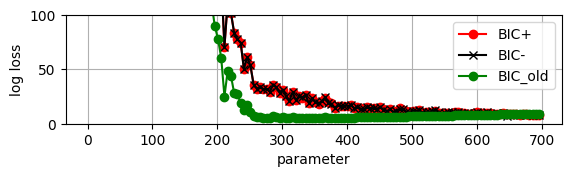

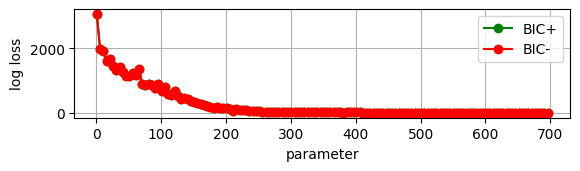

In [7]:
import torch
import numpy as np
from scipy.stats import multivariate_normal
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from torch.optim import Optimizer
from torch.autograd import grad
from torch.utils.data import TensorDataset

from sklearn.metrics import mean_squared_error
#parameter dimension
hidden_size_range = range(1, 700, 5)

input_dimension = 400  # Define your input size
num_classes = 1  # Define number of classes


lmbda = 0.001 # regularizer parameter
sigma =0.05   # sigma in paper

n = len(train_loader.dataset)
n_test=len(test_loader.dataset)
initial_std = sigma/(lmbda*n)
# Store the weights during training
weights_history = []
total_samples = 0

empirical_risks4=[]
empirical_risks1 = []
empirical_risks2 = []
empirical_risks3 = []
popluation_risks1 = []
popluation_risks3 = []
l2_regs = []
expression_values1 = []
expression_values2=[]
expression_values3=[]
expression_values4=[]
expression_values5=[]
expression_values6=[]


def get_num_samples(hidden_size, max_samples=200):
    # In this example, we're using a linear proportion, but you can adjust as needed
    min_proportion = 0.1
    max_proportion = 1.0

    proportion_range = max_proportion - min_proportion
    proportion = min_proportion + (hidden_size - min(hidden_size_range)) / (max(hidden_size_range) - min(hidden_size_range)) * proportion_range
    return int(proportion * max_samples)



for hidden_size in hidden_size_range:
    model = RandomFeatureModel(input_dimension, hidden_size, num_classes, initial_std,initialize_first_layer=False)
    total_l2_reg = 0
    total_loss = 0
    total_samples = 0
    empirical_risk=0
    B_list = []
    for inputs, _ in train_loader:
       with torch.no_grad():
             B_output = model(inputs, return_intermediate=True)
             B_list.append(B_output)
    B = torch.vstack(B_list)

    B_list = []
    for inputs, _ in test_loader:
       with torch.no_grad():
             B_output = model(inputs, return_intermediate=True)
             B_list.append(B_output)
    B_test = torch.vstack(B_list)

    I_p = torch.eye(hidden_size)
    Y_matrix = torch.cat([y for _, y in train_loader], dim=0)
    Y_test = torch.cat([y for _, y in test_loader], dim=0)

    #BTB
    BtB = torch.matmul(B.t(), B)
    #BTY
    BtY = torch.matmul(B.t(), Y_matrix.t())

    #W_lamda term
    W_lamda = torch.matmul(torch.inverse(lmbda * n * I_p + BtB), BtY)

    Sigma_W = sigma**2*torch.inverse(lmbda * n * I_p + BtB)
    W_lamda_WBIC = torch.matmul(torch.inverse(lmbda * n * I_p + np.log(n)*BtB), np.log(n)*BtY)

    Sigma_W_WBIC = sigma**2*torch.inverse(lmbda * n * I_p + np.log(n)*BtB)


    # L_p for MLE
    res_test = (Y_test - torch.matmul(B_test,W_lamda))
    term1_test = torch.matmul(res_test,res_test)
    popluation_risk3 = term1_test/(2*n_test*sigma**2)
    popluation_risks3.append(popluation_risk3)
    # L_p for Gibbs

    term2_test = torch.trace(torch.matmul(torch.matmul(B_test.t(), B_test), Sigma_W) )
    popluation_risk1 = (term1_test+term2_test) / (2*n_test*sigma**2)
    popluation_risks1.append(popluation_risk1)
    # L_E for Gibbs
    res = Y_matrix - torch.matmul(B,W_lamda)
    term1 = torch.matmul(res,res)

    res_WBIC= Y_matrix - torch.matmul(B,W_lamda_WBIC)
    term3=torch.matmul(res_WBIC,res_WBIC)
    term4=torch.trace(torch.matmul(BtB, Sigma_W_WBIC) )

    term2 = torch.trace(torch.matmul(BtB, Sigma_W) )

    empirical_risk1 = (term1+term2) / (2*n*sigma**2)
    empirical_risk4 = (term3+term4)/ (2*n*sigma**2)
    empirical_risks1.append(empirical_risk1)
    empirical_risks4.append(empirical_risk4)
    # L_E for MLE
    empirical_risks3.append(term1/ (2*n*sigma**2))


    # L_E for prior
    term1 = torch.matmul(Y_matrix,Y_matrix)
    term2 = sigma**2*torch.trace(BtB)/(n*lmbda)

    empirical_risk2 = (term1+term2) / (2*n*sigma**2)
    # avg_l2_reg = total_l2_reg / total_samples
    empirical_risks2.append(empirical_risk2)



    W1_term =lmbda*torch.matmul(W_lamda,W_lamda) / (2 * sigma**2)
    W2_term =torch.matmul(W_lamda.T,BtY) / (2 * n*sigma**2) #+(lmbda*noise_var**2)*torch.matmul(torch.matmul(torch.inverse(lmbda * n * I_p + BtB), BtY).T,torch.matmul(torch.inverse(lmbda * n * I_p + BtB), BtY) )/2#


    #trace term
    trace1_term = torch.trace(torch.inverse(I_p + BtB/(lmbda * n)))/(2 * n)
    trace2_term = torch.trace(I_p + BtB/(lmbda * n))/(2 * n)#+torch.trace(torch.inverse(I_p + BtB/(lmbda * n)) )/ (2 * n)#

    #det term
    sign, det_term = torch.slogdet(I_p + BtB/(lmbda * n))
    det_term /=2*n

    W_norm =torch.matmul(W_lamda,W_lamda)
    Sigma_trace = torch.trace(sigma**2*torch.inverse(lmbda * n * I_p + BtB))


    #divergence term
    expression_value1 = W1_term.item()+trace1_term.item() + det_term.item() - hidden_size/(2*n)#-0.5*(hidden_size/(lmbda*n)+ (3*hidden_size/(2*n)) -0.5-abs(0.5- hidden_size/(2*n)))/18

    expression_value2 = W2_term.item()+trace2_term.item() - det_term.item() - hidden_size/(2*n)
    #WBIC
    expression_value4 = W1_term.item()#0.5*(hidden_size/(lmbda*n)+ (3*hidden_size/(2*n)) -0.5-abs(0.5- hidden_size/(2*n)))

    expression_value5= trace1_term.item() + det_term.item() - hidden_size/(2*n)
    ##others
    # expression_value =(W_term.item())+hidden_size/(n*2)+det_term.item()/(2*n)#+term3.item()/(2*n) +hidden_size/(2*n)#+term3.item()/(2*n)+hidden_size/(2*n))# (term1.item() + hidden_size/(2*n) +term3.item()/(2*n))
    # expression_value2 = hidden_size/(n)
    expression_value3 = hidden_size/(2*n)*np.log(n)
    expression_value6= hidden_size/(n)
    expression_values1.append(expression_value1)
    expression_values2.append(expression_value2)

    expression_values3.append(expression_value3)
    expression_values6.append(expression_value6)
    expression_values4.append(expression_value4)
    expression_values5.append(expression_value5)
#Add empirical risk and divergence
BIC_plus = [x + y for x, y in zip(empirical_risks1, expression_values1)]

#Add with other term
BIC_minus = [x - y for x, y in zip(empirical_risks2, expression_values2)]

summed_values3 = [x + y for x, y in zip(empirical_risks3, expression_values3)]
summed_values4 = [x + y for x, y in zip(empirical_risks3, expression_values6)]

plt.figure()
plt.subplot(3,1,1)
plt.plot(list(hidden_size_range), BIC_plus, marker='o', color='r', label='BIC+')
plt.plot(list(hidden_size_range), BIC_minus, marker='x', color='k', label='BIC-')
plt.plot(list(hidden_size_range), summed_values3, marker='o', color='g',label='BIC_old')


plt.xlabel('parameter')
plt.ylabel('log loss')
plt.grid(True)
plt.ylim([0,100])
plt.legend()
plt.show()

plt.subplot(3,1,2)
plt.plot(list(hidden_size_range), BIC_plus, marker='o', color='g', label='BIC+')
plt.plot(list(hidden_size_range), BIC_minus, marker='o', color='r', label='BIC-')
#plt.plot(list(hidden_size_range), summed_values3, marker='o', color='k', label='BIC_old')
#plt.ylim([0,40])

#plt.title('KL-divergence')
plt.xlabel('parameter')
plt.ylabel('log loss')
plt.grid(True)
# plt.ylim([0,20])
plt.legend()
plt.show()



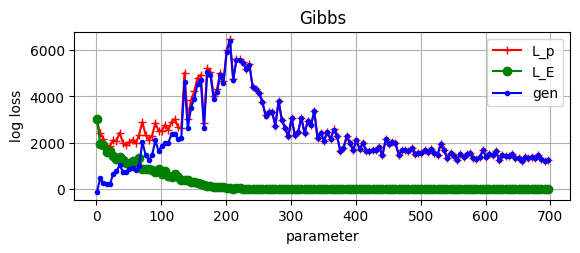

In [8]:
##Generalization Value#####
gen1 = [x - y for x, y in zip(popluation_risks1, empirical_risks1)]

###Plot Logloss########
plt.figure()
plt.subplot(2,1,1)
plt.plot(list(hidden_size_range), popluation_risks1, marker='+', color='r', label='L_p')
# plt.plot(list(hidden_size_range), np.array(expression_values1), marker='o', color='k', label='KL')
plt.plot(list(hidden_size_range), empirical_risks1, marker='o', color='g',label='L_E')

plt.plot(list(hidden_size_range), gen1, marker='.', color='b',label='gen')
#plt.plot(list(hidden_size_range), expression_values4, marker='.', color='m',label='W_1')


plt.title('Gibbs')

plt.xlabel('parameter')
plt.ylabel('log loss')
plt.grid(True)
plt.legend()
plt.show()



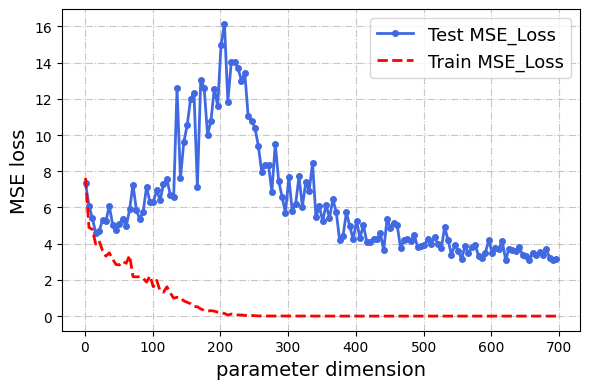

In [9]:
# Create a single plot for MSE performances
plt.figure(figsize=(6, 4))
MES_train = [value*sigma**2 for value in empirical_risks1]
MES_test = [value*sigma**2 for value in popluation_risks1]
# Define the interval for error bars (every 5 data points)
interval = 5

# Plot the train and test MSE performances with respect to the hidden size and include error bars
plt.plot(hidden_size_range, MES_test, '-o', color='royalblue', linewidth=2, markersize=4, label='Test MSE_Loss')
plt.plot(hidden_size_range, MES_train, 'r--', linewidth=2, markersize=4, label='Train MSE_Loss')

popluation_risks1
#plt.errorbar(hidden_size_range[::interval], final_test_mse_performances[::interval], yerr=final_sgld_test_losses_std[::interval], fmt='o', color='royalblue', ecolor='royalblue', capsize=4, markersize=4)

plt.xlabel('parameter dimension', fontsize=14)
plt.ylabel('MSE loss', fontsize=14)
plt.legend(fontsize=13)
#plt.title('Train and Test Log_Loss Performances ')
plt.grid(True, linestyle='-.', which='both', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [10]:
import math
lmbda = 0.001 # regularizer parameter
def shannon_transform_new(beta, gamma):
    temp_F = (math.sqrt(gamma * (1 + math.sqrt(beta))**2 + 1) - math.sqrt(gamma * (1 - math.sqrt(beta))**2 + 1))**2
    V = beta*(math.log(1 + gamma - (1/4) * temp_F)) +   math.log(1 + gamma * beta - ((1/4) * temp_F)) - ((1/4)/gamma) * temp_F
    return V

def F_function(beta, gamma):
    F = (math.sqrt(gamma * (1 + math.sqrt(beta))**2 + 1) - math.sqrt(gamma * (1 - math.sqrt(beta))**2 + 1))**2
    return F

# Define a function to calculate likelihood using negative MSE train loss
def likelihood(neg_mse_train_loss):
    return -neg_mse_train_loss

# Calculate GIBBS_BIC for each hidden size
gibbs_bic_list = []

# Calculate GIBBS_BIC for each hidden size
gibbs_bic_list = []
size=200
# Calculate GIBBS_BIC for each hidden size and store individual terms
gibbs_bic_list = []
mse_train_loss_term_list = []
l2_term_list = []
F_function_term_list = []
shannon_transform_term_list = []


for hidden_size_idx, hidden_size in enumerate(hidden_size_range):
    mse_train_loss = empirical_risks1[hidden_size_idx]
    l2_reg =expression_values4[hidden_size_idx]
    beta = hidden_size / size
    gamma = 1.0 / lmbda

    mse_train_loss_term = mse_train_loss
    l2_term = l2_reg
    F_function_term = (F_function(beta, gamma) / (8 * gamma))
    shannon_transform_term = 0.5 * shannon_transform_new(beta, gamma)


    gibbs_bic = mse_train_loss_term + l2_term - F_function_term + shannon_transform_term

    mse_train_loss_term_list.append(mse_train_loss_term)
    l2_term_list.append(l2_term)
    F_function_term_list.append(F_function_term)
    shannon_transform_term_list.append(shannon_transform_term)
    gibbs_bic_list.append(gibbs_bic)

# Find the index of the lowest GIBBS_BIC value
min_gibbs_bic_idx = gibbs_bic_list.index(min(gibbs_bic_list))

# Print the GIBBS_BIC values for each hidden size
for hidden_size_idx, SGLD_hidden_size in enumerate(hidden_size_range):
    beta = SGLD_hidden_size / size
    gibbs_bic_star = '*' if hidden_size_idx == min_gibbs_bic_idx else ''
    # print(f'Hidden size: {sgld_train_losses_avg2[hidden_size_idx][-1]}')
    # print(f'Hidden size: {SGLD_hidden_size}')
    # print(f'  GIBBS_BIC: {gibbs_bic_list[hidden_size_idx]:.4f}{gibbs_bic_star}')
    # print(f'V_term: { 0.5 * shannon_transform_new(beta, gamma)}')
    # print(f'V_term: {l2_term_list[hidden_size_idx]}' )
    # print()  # Add a blank line for better readability

# Choose the hidden size with the minimum GIBBS_BIC value
best_hidden_size = hidden_size_range[min_gibbs_bic_idx]
# print(f'The best hidden size according to GIBBS_BIC is: {best_hidden_size}')



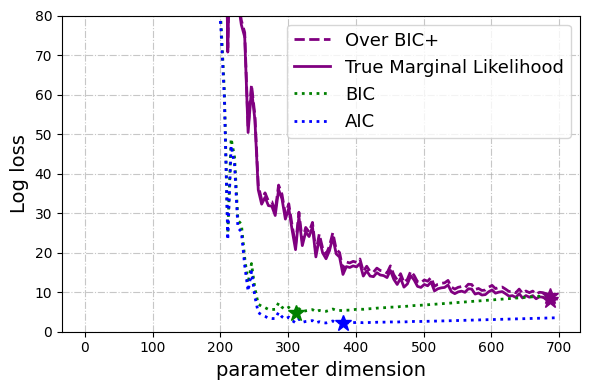

In [11]:
plt.figure(figsize=(6, 4))
plt.errorbar(hidden_size_range, gibbs_bic_list, label='Over BIC+', linestyle='--', linewidth=2, capsize=4,color='purple')
plt.errorbar(hidden_size_range, BIC_plus, label='True Marginal Likelihood', linestyle='-', linewidth=2, capsize=4,color='purple')
plt.errorbar(hidden_size_range, summed_values3, label='BIC', linestyle=':', linewidth=2, capsize=4,color='green')
plt.errorbar(hidden_size_range, summed_values4, label='AIC', linestyle=':', linewidth=2, capsize=4,color='blue')

plt.ylim([0,80])
# Find the index of the minimum value in each list
min_bic_index = np.argmin(BIC_plus)
min_bic2_index=np.argmin(gibbs_bic_list)
min_sgld_bic_index = np.argmin(summed_values3)
min_aic_index = np.argmin(summed_values4)

# Get the minimum value points
# Get the minimum value points
min_bic_point = (hidden_size_range[min_bic_index], BIC_plus[min_bic_index])
min_bic2_point = (hidden_size_range[min_bic2_index], gibbs_bic_list[min_bic2_index])

min_sgld_bic_point = (hidden_size_range[min_sgld_bic_index], summed_values3[min_sgld_bic_index])
min_wbic_point = (hidden_size_range[min_aic_index], summed_values4[min_aic_index])

# Add markers for the minimum value points
plt.plot(*min_bic_point, marker='*', markersize=12, color='purple',  zorder=3)
plt.plot(*min_bic2_point, marker='*', markersize=12, color='purple',  zorder=3)
plt.plot(*min_sgld_bic_point, marker='*', markersize=12, color='green', zorder=3)
plt.plot(*min_wbic_point, marker='*', markersize=12, color='blue', zorder=3)


plt.xlabel('parameter dimension', fontsize=14)
plt.ylabel('Log loss', fontsize=14)
plt.legend(fontsize=13)
#plt.title('Overparametrized BIC and Underparametrized BIC')
plt.grid(True, linestyle='-.', which='both', alpha=0.7)
plt.tight_layout()
plt.show()

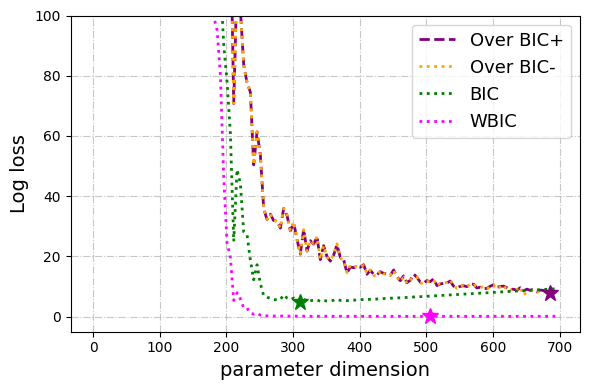

In [12]:
plt.figure(figsize=(6, 4))

plt.errorbar(hidden_size_range, BIC_plus, label='Over BIC+', linestyle='--', linewidth=2, capsize=4,color='purple')
plt.errorbar(hidden_size_range, BIC_minus, label='Over BIC-', linestyle=':', linewidth=2, capsize=4,color='orange')
plt.errorbar(hidden_size_range, summed_values3, label='BIC', linestyle=':', linewidth=2, capsize=4,color='green')
plt.errorbar(hidden_size_range, empirical_risks4, label='WBIC', linestyle=':', linewidth=2, capsize=4,color='magenta')
#plt.errorbar(hidden_size_range, summed_values2, label='BIC-', linestyle=':', linewidth=2, capsize=4,color='blue')

plt.ylim([0,100])
# Find the index of the minimum value in each list
min_bic_index = np.argmin(BIC_plus)
min_sgld_bic_index = np.argmin(summed_values3)
min_wbic_index = np.argmin(empirical_risks4)

# Get the minimum value points
# Get the minimum value points
min_bic_point = (hidden_size_range[min_bic_index], BIC_plus[min_bic_index])
min_sgld_bic_point = (hidden_size_range[min_sgld_bic_index], summed_values3[min_sgld_bic_index])
min_wbic_point = (hidden_size_range[min_wbic_index], empirical_risks4[min_wbic_index])

# Add markers for the minimum value points
plt.plot(*min_bic_point, marker='*', markersize=12, color='purple',  zorder=3)
plt.plot(*min_sgld_bic_point, marker='*', markersize=12, color='green', zorder=3)
plt.plot(*min_wbic_point, marker='*', markersize=12, color='magenta', zorder=3)

plt.ylim([-5,100])
plt.xlabel('parameter dimension', fontsize=14)
plt.ylabel('Log loss', fontsize=14)
plt.legend(fontsize=13)
#plt.title('Overparametrized BIC and Underparametrized BIC')
plt.grid(True, linestyle='-.', which='both', alpha=0.7)
plt.tight_layout()
plt.show()

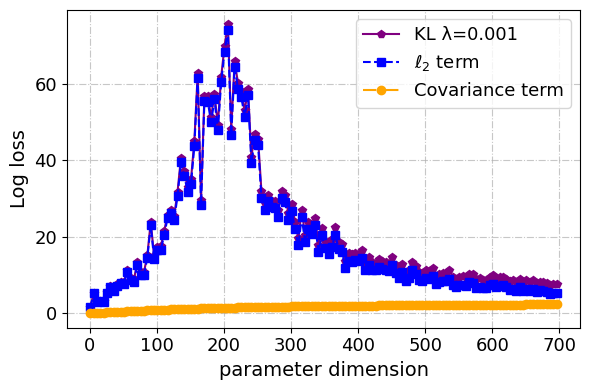

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(hidden_size_range, expression_values1, label=f'KL λ={lmbda}', color='purple', linestyle='-', marker='p', markersize=6)

plt.plot(hidden_size_range, expression_values4, label='$\ell_2$ term', color='blue', linestyle='--', marker='s', markersize=6)

plt.plot(hidden_size_range, expression_values5, label='Covariance term',   color='orange',linestyle='-.', marker='o', markersize=6)
#plt.plot(hidden_size_range, expression_values5, label='Train loss', color='red', linestyle='--',  markersize=8)

plt.xlabel('parameter dimension',fontsize=14)
plt.ylabel('Log loss',fontsize=14)
plt.legend(fontsize=13)
plt.grid(True, linestyle='-.', which='both', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=13)  # Increase tick label font size
#plt.ylim([0,24])
plt.tight_layout()
plt.show()